# Hands on Covid-19 modeling with Bayesian Parameter Estimation 
Bayesian linear regression is still linear regression. But unlike frequentists, Bayesian statisticians use prior beliefs to define a probability distribution on unknown parameters whereas frequentists believes probabilities represent long run frequencies with which events occur. A great introduction to Bayesian can be found at <a href="https://www.amazon.com/Statistical-Rethinking-Bayesian-Examples-Chapman/dp/1482253445/" target="_blank">this link</a>. 


#  Pymc3 package

https://docs.pymc.io/notebooks/getting_started.html#:~:text=PyMC3%20has%20the%20standard%20sampling,MCMC%20algorithms%20work%20very%20slowly.

In [ ]:
#conda install m2w64-toolchain

In [ ]:
#conda install numpy scipy mkl-service libpython

In [ ]:
#!pip install arviz pymc3==3.8
!pip install wget


# 8. Data Cleaning and Visualization

In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import wget

In [2]:
import requests
import io
    


In [ ]:
# url of the raw csv dataset
urls = [
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
]
[wget.download(url) for url in urls]

In [152]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_US.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_US.csv')

In [4]:
confirmed_df.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '8/22/20', '8/23/20', '8/24/20', '8/25/20', '8/26/20', '8/27/20',
       '8/28/20', '8/29/20', '8/30/20', '8/31/20'],
      dtype='object', length=234)

In [5]:
##columsn without date
confirmed_df.columns[:11]

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'],
      dtype='object')

In [6]:
# Convert date rows into columns
dates = confirmed_df.columns[11:]

confirmed_df_long = confirmed_df.melt(
    id_vars=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed'
)


In [7]:
confirmed_df_long

UID iso2 iso3  code3     FIPS      Admin2 Province_State  \
0       84001001   US  USA    840   1001.0     Autauga        Alabama   
1       84001003   US  USA    840   1003.0     Baldwin        Alabama   
2       84001005   US  USA    840   1005.0     Barbour        Alabama   
3       84001007   US  USA    840   1007.0        Bibb        Alabama   
4       84001009   US  USA    840   1009.0      Blount        Alabama   
...          ...  ...  ...    ...      ...         ...            ...   
744815  84056039   US  USA    840  56039.0       Teton        Wyoming   
744816  84056041   US  USA    840  56041.0       Uinta        Wyoming   
744817  84090056   US  USA    840  90056.0  Unassigned        Wyoming   
744818  84056043   US  USA    840  56043.0    Washakie        Wyoming   
744819  84056045   US  USA    840  56045.0      Weston        Wyoming   

       Country_Region        Lat       Long_             Combined_Key  \
0                  US  32.539527  -86.644082     Autauga, Alabama, US   
1                  US  30.727750  -87.722071     Baldwin, Alabama, US   
2                  US  31.868263  -85.387129     Barbour, Alabama, US   
3                  US  32.996421  -87.125115        Bibb, Alabama, US   
4                  US  33.982109  -86.567906      Blount, Alabama, US   
...               ...        ...         ...                      ...   
744815             US  43.935225 -110.589080       Teton, Wyoming, US   
744816             US  41.287818 -110.547578       Uinta, Wyoming, US   
744817             US   0.000000    0.000000  Unassigned, Wyoming, US   
744818             US  43.904516 -107.680187    Washakie, Wyoming, US   
744819             US  43.839612 -104.567488      Weston, Wyoming, US   

           Date  Confirmed  
0       1/22/20          0  
1       1/22/20          0  
2       1/22/20          0  
3       1/22/20          0  
4       1/22/20          0  
...         ...        ...  
744815  8/31/20        430  
744816  8/31/20        298  
744817  8/31/20         73  
744818  8/31/20        108  
744819  8/31/20         11  

[744820 rows x 13 columns]

In [8]:
US_confirmed = confirmed_df_long[['Admin2','Province_State',  'Lat','Long_','Date','Confirmed']]
US_confirmed = US_confirmed.rename(columns={"Admin2": "County", "Province_State": "State"})
# Check for null
US_confirmed.isnull().sum()

County       1338
State           0
Lat             0
Long_           0
Date            0
Confirmed       0
dtype: int64

In [10]:
## Select california state from US with cases more than 10
cal = US_confirmed[US_confirmed["State"] == "California" ]
cal_10 = cal[cal['Confirmed']>=10]
cal_10
cal_10

County       State        Lat       Long_     Date  Confirmed
137178  Santa Clara  California  37.231049 -121.697046   3/3/20         11
140518  Santa Clara  California  37.231049 -121.697046   3/4/20         11
143833  Los Angeles  California  34.308284 -118.228241   3/5/20         11
143858  Santa Clara  California  37.231049 -121.697046   3/5/20         20
147173  Los Angeles  California  34.308284 -118.228241   3/6/20         13
...             ...         ...        ...         ...      ...        ...
741729       Tulare  California  36.220266 -118.802020  8/31/20      14079
741730     Tuolumne  California  38.026440 -119.952509  8/31/20        189
741732      Ventura  California  34.444657 -119.091061  8/31/20      10775
741733         Yolo  California  38.682789 -121.901829  8/31/20       2424
741734         Yuba  California  39.262559 -121.353564  8/31/20        927

[7957 rows x 6 columns]

## LA County with more than 10 cases orderd by Date

#### Cumulative sum is by County, not as a whole state. To get the total cases in 'California' state, we must sum the latest case of each county

In [145]:
# Choose LA and orderd by date
la = cal_10[cal_10['County']== 'Los Angeles']
la = la[['Date','Confirmed']]
la['Confirmed']

143833        11
147173        13
150513        14
153853        14
157193        14
           ...  
728333    236986
731673    238458
735013    239756
738353    240749
741693    241768
Name: Confirmed, Length: 180, dtype: int64

In [12]:
alt.Chart(la).mark_line().encode(
    x='Date:T',
    y='Confirmed').interactive()



alt.Chart(...)

# Bayesian Exponential Infection Model

## Growth = a * (1+b) ** t

t = cumulative number of days  
a = Y - intercept  
b = growth rate  


Exponential growth rates
There are a variety of fitted growth rates appearing in the literature. Could spend all day reading about it. It looks like a value of 0.2 is appropriate for larger countries.

India (0.18-0.19), Ganesh Kumar et al., http://arxiv.org/abs/2003.12017
China (0.24), Wu et al., https://arxiv.org/pdf/2003.05681.pdf
China (0.22), Batista, https://www.medrxiv.org/content/10.1101/2020.03.11.20024901v2.full.pdf

In [13]:
la.columns

Index(['Date', 'Confirmed'], dtype='object')

In [14]:
county = "Los Angeles "
days_since_10 = range(len(la))


# Create PyMC3 context manager
with pm.Model() as model:
  t = pm.Data(county +"x_data", days_since_10)
  confirmed_cases = pm.Data(county + "y_data", la["Confirmed"].astype('float64').values)
    
    # Priors
  # Intercept - We fixed this at 10 since we cut off at 10.
  a = pm.Normal("a", mu=10, sigma=0.10)

  # Slope - Growth rate: 0.2 seems to be the normal 
  b = pm.Normal("b", mu=0.2, sigma=0.01)

  # Exponential regression
  growth = a * (1 + b) ** t

  # Likelihood error
  eps = pm.HalfNormal("eps")

  # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
  pm.Lognormal(county, mu=np.log(growth), sigma=eps, observed=confirmed_cases)
    
  trace = pm.sample()
# This takes the parameters from posterior distribution and generate data
  post_Pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 4000/4000 [00:05<00:00, 770.62draws/s]
The acceptance probability does not match the target. It is 0.8823780947693831, but should be close to 0.8. Try to increase the number of tuning steps.
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 109.99it/s]


In [15]:
trace['a']
trace['b']
trace['eps']

array([2.58923953, 2.50029506, 2.28533752, ..., 2.63448748, 2.19764333,
       2.50196749])

C:\Users\kicks\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


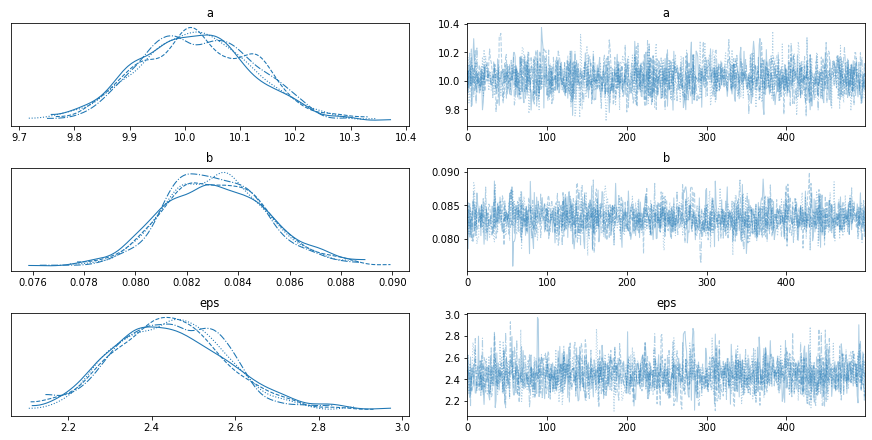

In [16]:
pm.traceplot(trace)
plt.show()


In [17]:
pm.summary(trace)

C:\Users\kicks\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a    10.021  0.102   9.840   10.213      0.002    0.002    2191.0  2188.0   
b     0.083  0.002   0.080    0.087      0.000    0.000    2231.0  2211.0   
eps   2.446  0.135   2.192    2.697      0.003    0.002    1859.0  1859.0   

     ess_bulk  ess_tail  r_hat  
a      2182.0    1350.0    1.0  
b      2268.0    1204.0    1.0  
eps    1786.0    1354.0    1.0

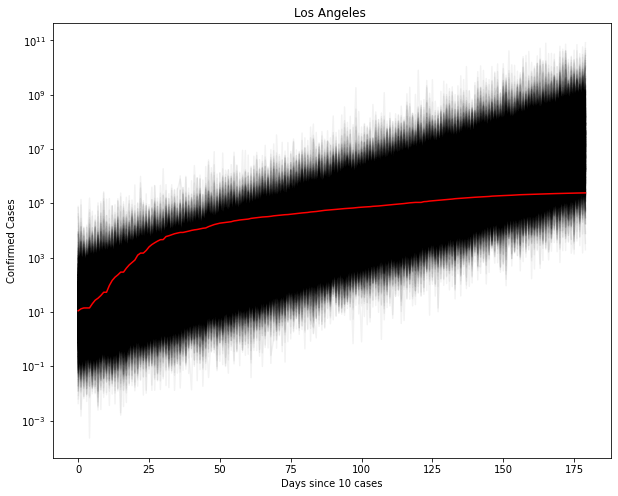

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(range(len(la)), post_Pred[county].T, color="k", alpha=0.05)
ax.plot(range(len(la)), la["Confirmed"].astype('float64').values, color="r")
ax.set_yscale("log")
ax.set(xlabel="Days since 10 cases", ylabel="Confirmed Cases", title=county)
plt.show()


## Exponential Model w/ backtesting

Typically, we build a model, train a model, then call a prediction function with different data to see the predictions. 
But in pymc3, the data is a part of the model. So, how do we test with different data?  
Solution: We can build a model generation function and call that twice with different data. 

In [20]:
def mymodel(county: str, x: np.ndarray, y: np.ndarray):
    with pm.Model() as model:
      t = pm.Data(county+"x_data", x)
      confirmed_cases = pm.Data(county + "y_data", y)

        # Priors
      # Intercept - We fixed this at 100 since we cut off at 100. 
      a = pm.Normal("a", mu=10, sigma=0.1)
      b = pm.Normal("b", mu=0.2, sigma=0.01)

      # Exponential regression
      growth = a * (1 + b) ** t

      # Likelihood error
      eps = pm.HalfNormal("eps")

      # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
      pm.Lognormal(county, mu=np.log(growth), sigma=eps, observed=confirmed_cases)
    return model

In [22]:
train_x = np.arange(0,175)
train_y = la['Confirmed'].astype('float64').values[:-5]
hold_out_y = la['Confirmed'].astype('float64').values[-5:]
hold_out_x = np.arange(len(train_x)+1, len(la)+1)


### Training

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 4000/4000 [00:05<00:00, 740.36draws/s]
The acceptance probability does not match the target. It is 0.9101257739761135, but should be close to 0.8. Try to increase the number of tuning steps.
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 109.14it/s]


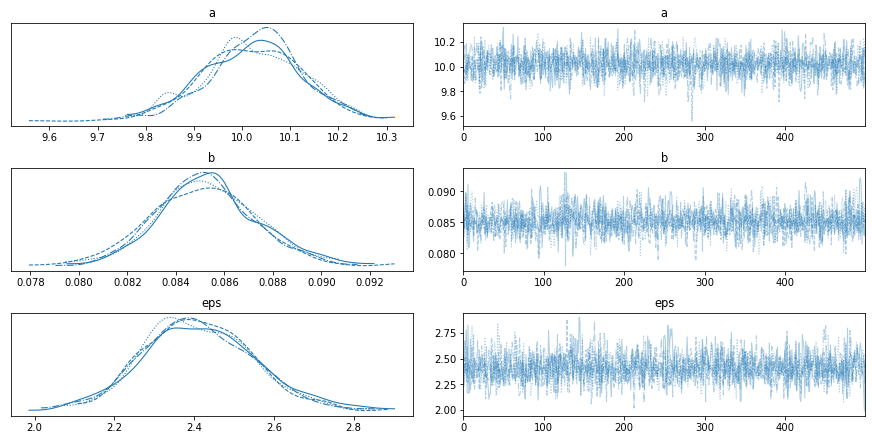

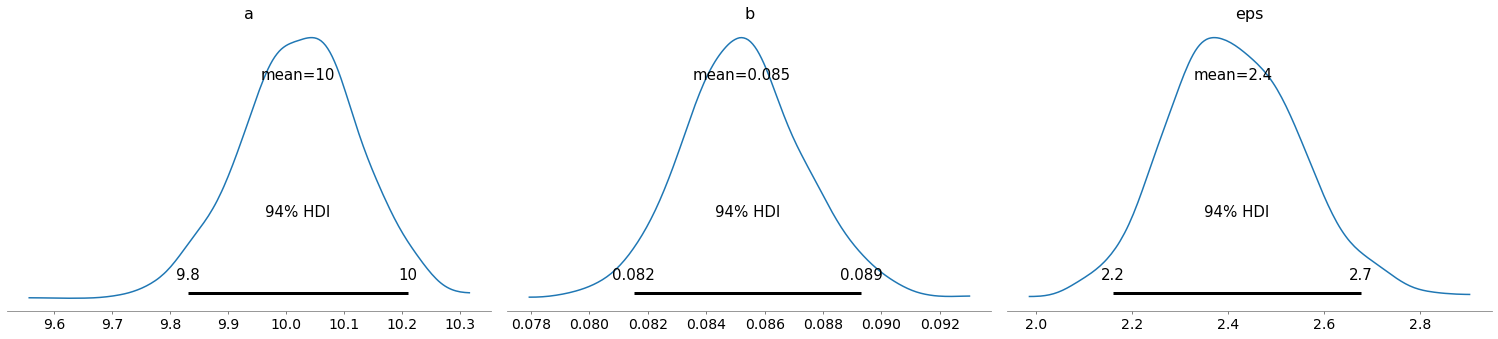

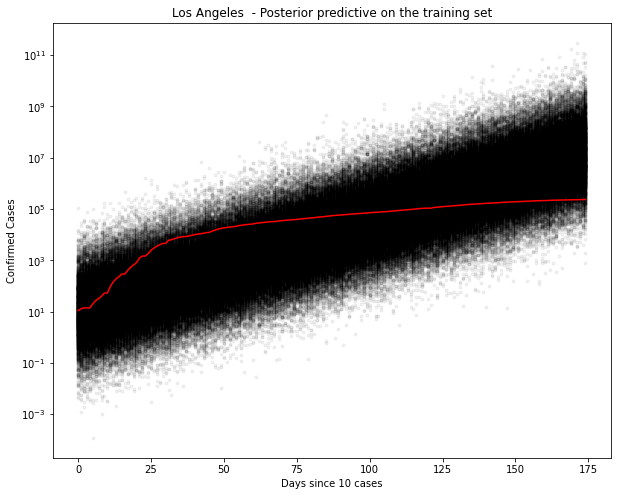

In [23]:
with mymodel(county, train_x, train_y) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(train_x, ppc[county].T, ".k", alpha=0.05)
    ax.plot(train_x, train_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Days since 10 cases", ylabel="Confirmed Cases", title=f"{county} - Posterior predictive on the training set")


In [29]:
pm.summary(train_trace)

C:\Users\kicks\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a    10.021  0.100   9.832   10.210      0.002    0.002    1983.0  1983.0   
b     0.085  0.002   0.082    0.089      0.000    0.000    2063.0  2049.0   
eps   2.411  0.137   2.159    2.676      0.003    0.002    2069.0  2060.0   

     ess_bulk  ess_tail  r_hat  
a      2012.0    1359.0    1.0  
b      2085.0    1283.0    1.0  
eps    2070.0    1220.0    1.0

### Model with holdout data

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 110.18it/s]


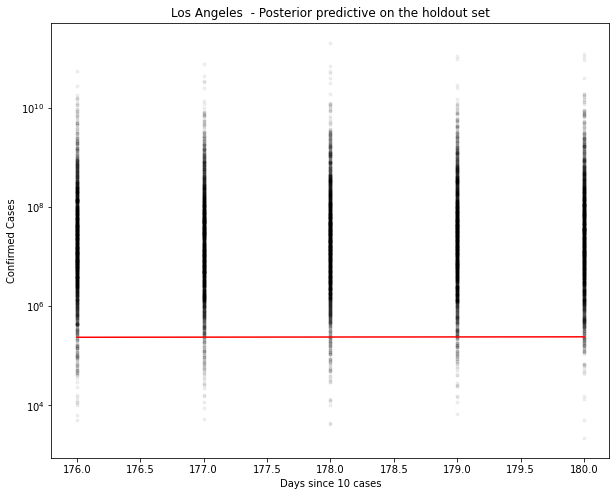

In [24]:
# New model with holdout data
# Model trained with holdout data but will do predictions usinng posterior parameters from training model
with mymodel(county, hold_out_x, hold_out_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(hold_out_x, ppc[county].T, ".k", alpha=0.05)
    ax.plot(hold_out_x, hold_out_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Days since 10 cases", ylabel="Confirmed Cases", title=f"{county} - Posterior predictive on the holdout set")

Seems to be a slight downward approach??

A single prediction is the maximum likelihood of that distribution. For now, let's use the mean

In [26]:
# Generate the predicted number of cases (assuming normally distributed on the output)
predicted_cases = ppc[county].mean(axis=0).round()
print(predicted_cases)

[3.03459162e+08 3.28390570e+08 4.71682513e+08 4.06926444e+08
 5.10739524e+08]


In [ ]:
## Prediction errors

In [27]:
def error(actual, predicted):
  return predicted - actual

def print_errors(actuals, predictions):
  for n in [1,5]:
    act, pred = actuals[n-1], predictions[n-1]
    err = error(act, pred)
    print(f"{n}-day cumulative prediction error: {err} cases ({100 * err / act} %)")

print_errors(hold_out_y, predicted_cases)

print(hold_out_y)


1-day cumulative prediction error: 303222176.0 cases (127949.40460617926 %)
5-day cumulative prediction error: 510497756.0 cases (211151.91257734687 %)
[236986. 238458. 239756. 240749. 241768.]


There are a number of ways we can make this more complicated:  

Backtesting over different time periods (i.e. not just the last 5 days, but 5 in the middle too)
Cross-validation (training many models on different random holdouts and look at the average and standard deviation of those errors)
Use more states
But obviously the exponential model doesn’t work very well. 

In [28]:
new_x = [hold_out_x[-1] + 1, hold_out_x[-1] + 5]
new_y = [0, 0]
# Predictive model
with mymodel(county, new_x, new_y) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
predicted_cases = ppc[county].mean(axis=0).round()
print("\n")
print(f"Based upon this model, tomorrow's number of cases will be {predicted_cases[0]}. In 5 days time there will be {predicted_cases[1]} cases.")
print("NOTE: These numbers are based upon a bad model. Don't use them!")

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 102.95it/s]



Based upon this model, tomorrow's number of cases will be 581632515.0. In 5 days time there will be 532445252.0 cases.
NOTE: These numbers are based upon a bad model. Don't use them!


## Logistic Model

$$ C(t) = \frac{K}{1+ Ae^-rt} $$  
Differential form:  
$$\frac{dC}{dt} = rC(1-\frac{C}{K}) $$  where
$$ C =\frac{K-C_0}{C_0}$$  
C  is an accumulated number of cases, r>0 is the infection rate, and K>0 is the final epidemic size.  
$C_0 $ is the initial number of cases at time zero.

[Text(0, 0.5, 'Cases'), Text(0.5, 0, 'Days since...')]

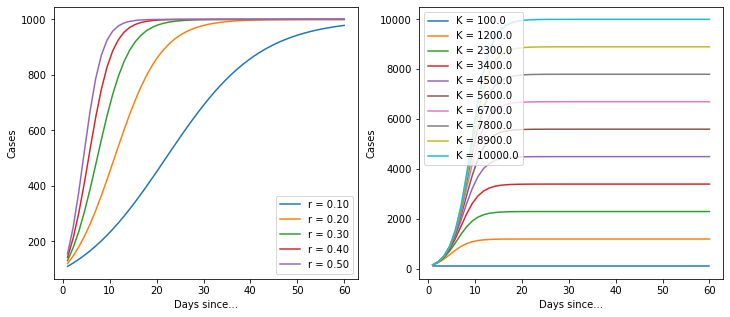

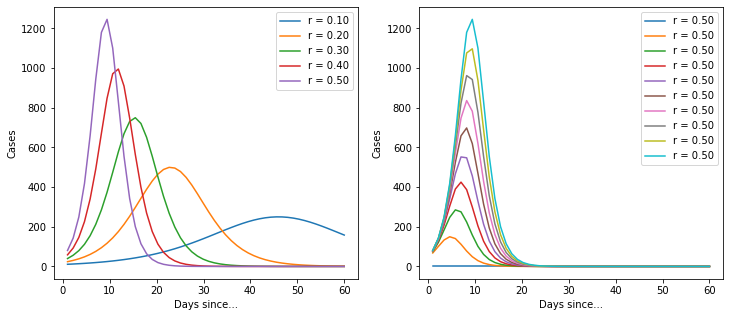

In [30]:
def C(K, r, t, C_0):
  A = (K-C_0)/C_0
  return K / (1 + A * np.exp(-r * t))

def d_C(K, r, t, C_0):
  c = C(K, r, t, C_0)
  return r * c * (1 - c / K)

r = 0.2
K = 1000
C_0 = 100

t = np.linspace(1,60)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
for r in np.linspace(0.1, 0.5, 5):
  ax[0].plot(t, C(K, r, t, C_0), label=f"r = {r:0.2f}")
ax[0].legend(loc="best")
ax[0].set(xlabel="Days since...", ylabel="Cases")
for K in np.linspace(100, 10000, 10):
  ax[1].plot(t, C(K, r, t, C_0), label=f"K = {K:0.1f}")
ax[1].legend(loc="best")
ax[1].set(xlabel="Days since...", ylabel="Cases")

fig, ax = plt.subplots(1, 2, figsize=(12,5))
for r in np.linspace(0.1, 0.5, 5):
  ax[0].plot(t, d_C(K, r, t, C_0), label=f"r = {r:0.2f}")
ax[0].legend(loc="best")
ax[0].set(xlabel="Days since...", ylabel="Cases")
for K in np.linspace(100, 10000, 10):
  ax[1].plot(t, d_C(K, r, t, C_0), label=f"r = {r:0.2f}")
ax[1].legend(loc="best")
ax[1].set(xlabel="Days since...", ylabel="Cases")

In [39]:
county = "Los Angeles "
def mymodel(county: str, x: np.ndarray, y: np.ndarray,population: float, proportion: float ):
  with pm.Model() as model:
    t = pm.Data(county + "x_data", x)
    confirmed_cases = pm.Data(county + "y_data", y)

    # Intercept - We fixed this at 10 since we start at 10.
    C_0 = pm.Normal("C_0", mu=10, sigma=0.1)

    # Growth rate: 0.2 is approx value reported by others
    r = pm.Normal("r", mu=0.2, sigma=0.01)

    # Total number of cases. Depends on the population, more people, more infections.
    # It also depends on the total number of people infected.
    # Start with a prior based upon a guess of the initial population, very weak
    proportion_infected = proportion # This value is rough estimate using data
    p = population ## modify it as prior and see how the model corresponds
    K = pm.Normal("K", mu=p * proportion_infected, sigma=p*0.1)

    # Logistic regression
    growth = C(K, r, t, C_0)

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal(county, mu=np.log(growth), sigma=eps, observed=confirmed_cases)
  return model

## Model testing
Let’s train it on some synthetic data to begin with to make sure the model can actually fit it.

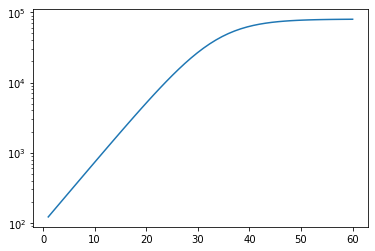

In [34]:
r = 0.2
K = 80000 # This should look something a bit like China
C_0 = 100
t = np.linspace(1,60)
y_synthetic = C(K, r, t, C_0)
plt.plot(t, y_synthetic)
plt.gca().set_yscale("log")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, K, r, C_0]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 4000/4000 [00:05<00:00, 740.70draws/s]
The acceptance probability does not match the target. It is 0.8909591268373405, but should be close to 0.8. Try to increase the number of tuning steps.
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 105.03it/s]


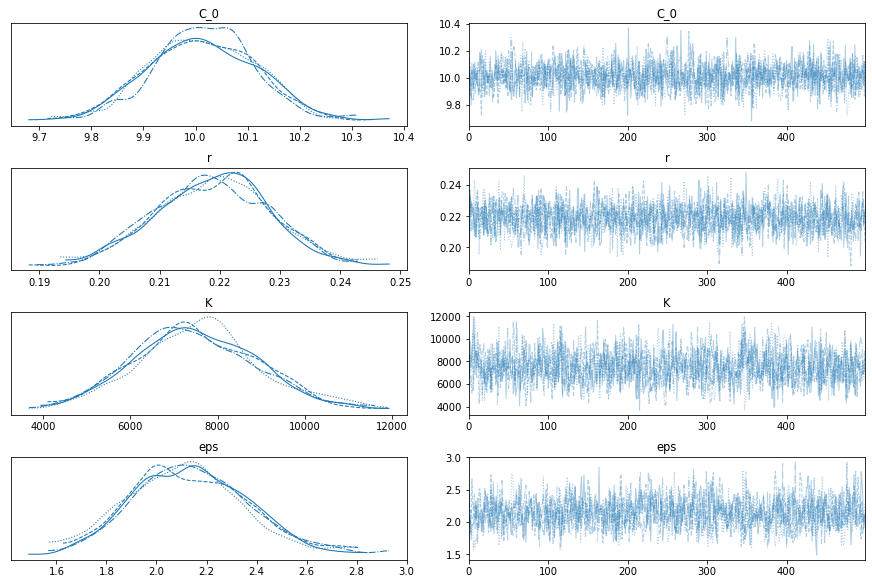

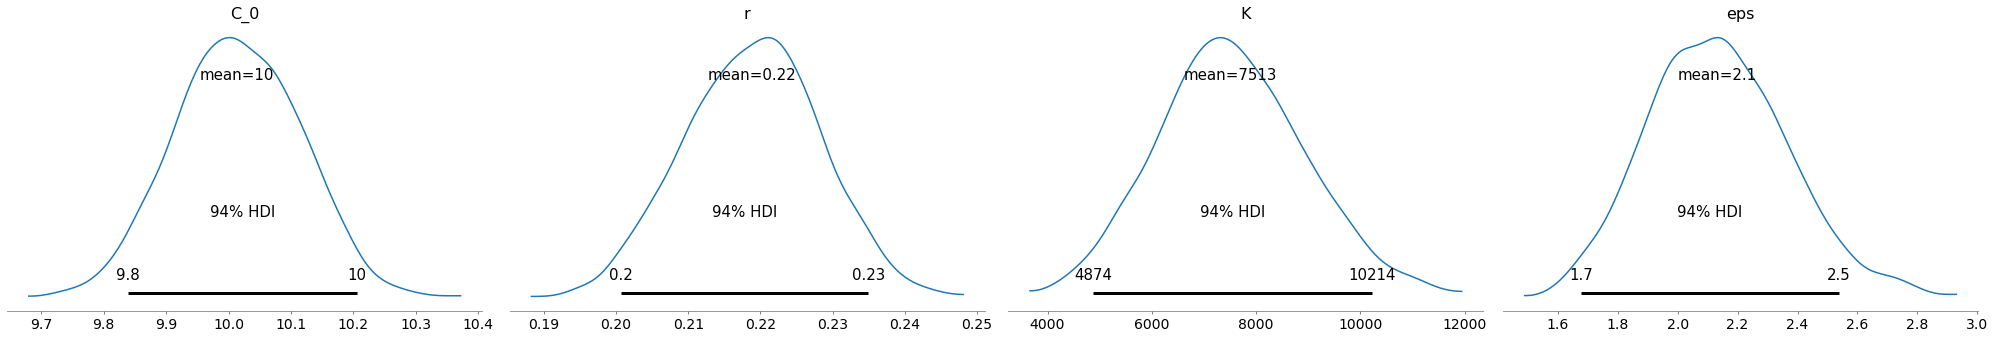

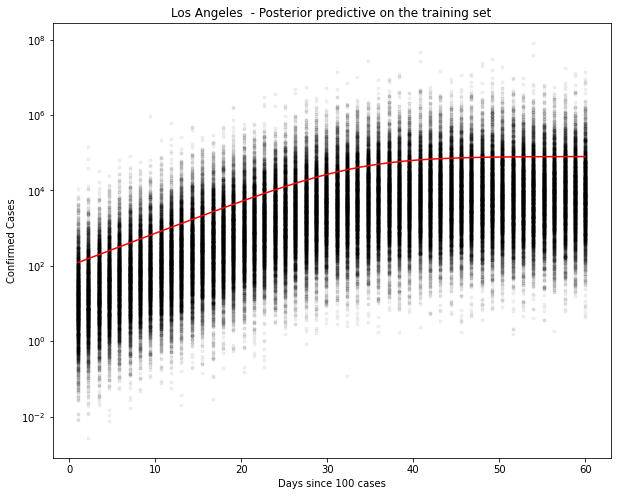

In [42]:
with mymodel(county, t, y_synthetic,20000,0.02) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(t, ppc[county].T, ".k", alpha=0.05)
    ax.plot(t, y_synthetic, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Days since 10 cases", ylabel="Confirmed Cases", title=f"{county} - Posterior predictive on the training set")

## Model training with real data

In [57]:
la['Confirmed'].iloc[-1]/10039107

0.024082620097584377

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, K, r, C_0]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 4000/4000 [00:07<00:00, 543.06draws/s]
The acceptance probability does not match the target. It is 0.9173567195189996, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9118297657379779, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9256837764511341, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9221642770294414, but should be close to 0.8. Try to increase the number of tuning steps.
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 105.02it/s]


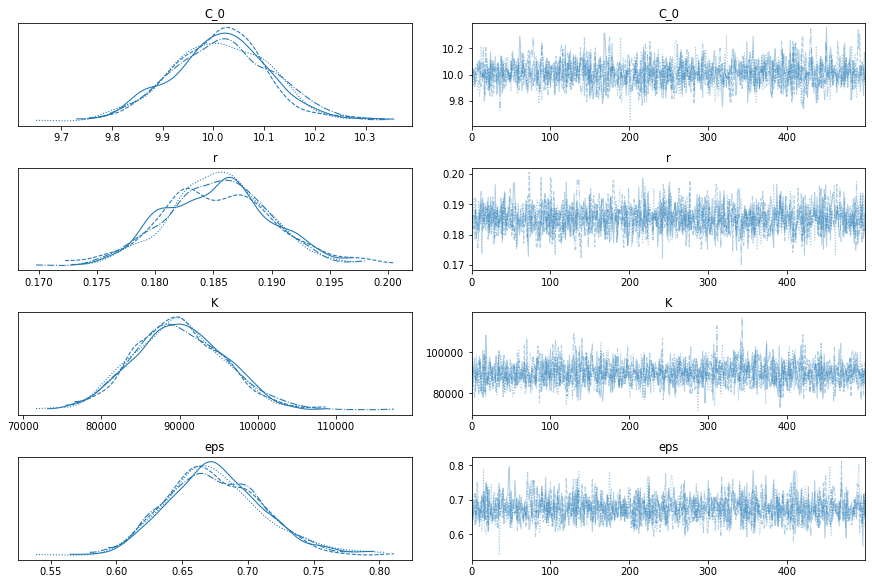

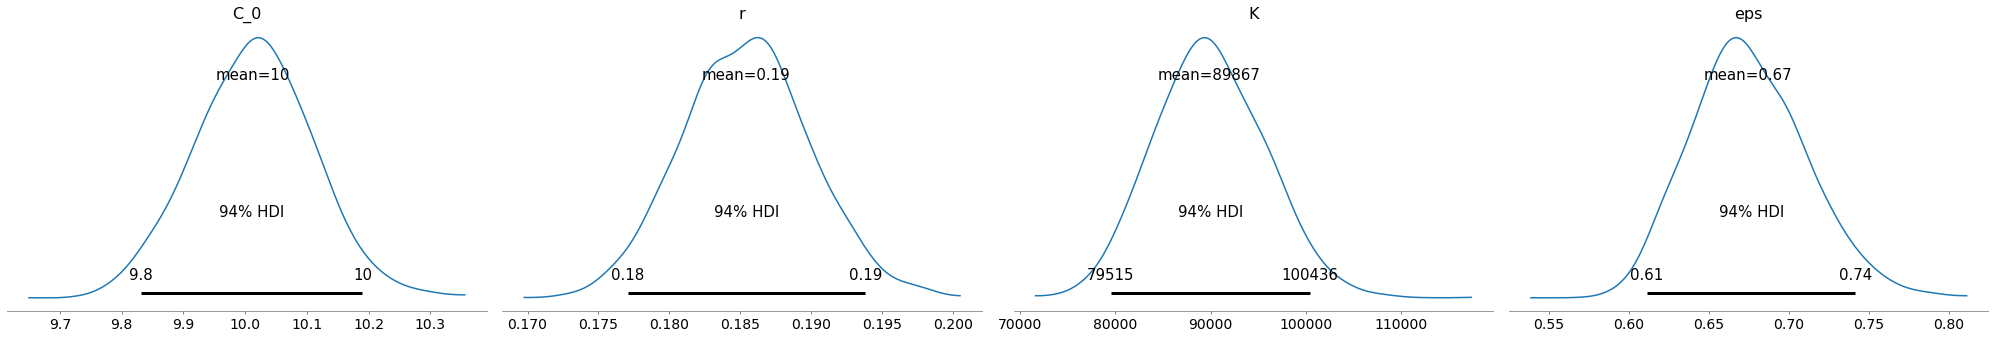

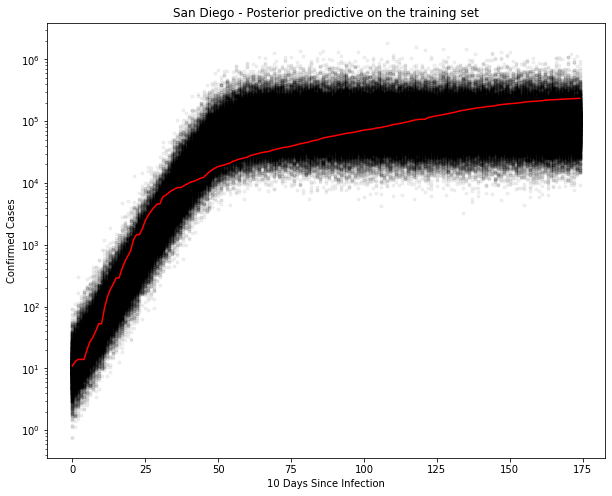

In [138]:
# Training
with mymodel(county, train_x, train_y,10039107,la['Confirmed'].iloc[-1]/10039107.0) as model:
    train_trace = pm.sample()
    pm.traceplot(train_trace)
    pm.plot_posterior(train_trace)
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(train_x, ppc[county].T, ".k", alpha=0.05)
    ax.plot(train_x, train_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="10 Days Since Infection", ylabel="Confirmed Cases", title=f"{county} - Posterior predictive on the training set")
    

In [59]:
pm.summary(train_trace)

C:\Users\kicks\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean        sd     hdi_3%     hdi_97%  mcse_mean  mcse_sd  ess_mean  \
C_0     10.010     0.100      9.823      10.196      0.002    0.002    2085.0   
r        0.186     0.005      0.177       0.194      0.000    0.000    1842.0   
K    90135.021  6105.619  79442.299  101829.102    144.052  102.907    1796.0   
eps      0.676     0.036      0.612       0.745      0.001    0.001    1588.0   

     ess_sd  ess_bulk  ess_tail  r_hat  
C_0  2085.0    2101.0    1426.0    1.0  
r    1824.0    1890.0    1325.0    1.0  
K    1761.0    1839.0    1564.0    1.0  
eps  1557.0    1673.0    1121.0    1.0

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 105.66it/s]


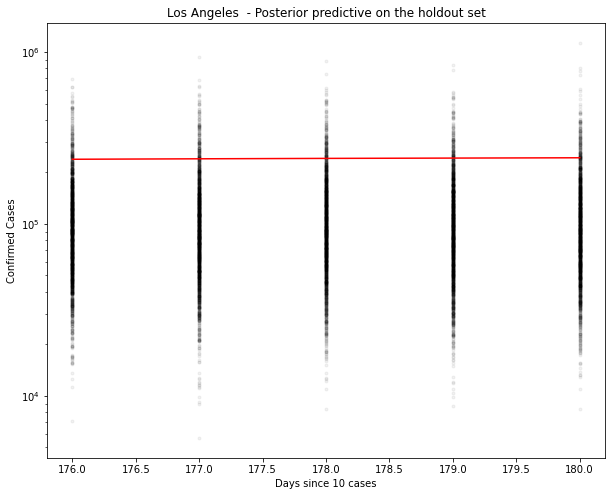

In [61]:
# New model with holdout data
with mymodel(county, hold_out_x, hold_out_y,10039107,la['Confirmed'].iloc[-1]/10039107.0) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(hold_out_x, ppc[county].T, ".k", alpha=0.05)
    ax.plot(hold_out_x, hold_out_y, color="r")
    ax.set_yscale("log")
    ax.set(xlabel="Days since 10 cases", ylabel="Confirmed Cases", title=f"{county} - Posterior predictive on the holdout set")

In [68]:
predicted_cases = ppc[county].mean(axis=0).round()
print(predicted_cases)
def error(actual, predicted):
  return predicted - actual

def print_errors(actuals, predictions):
  for n in [1, 5]:
    act, pred = actuals[n-1], predictions[n-1]
    err = error(act, pred)
    print(f"{n}-day cumulative prediction error: {err} cases ({100 * err / act:.1f} %)")

print_errors(hold_out_y, predicted_cases)

[111862. 111926. 115100. 110908. 111662.]
1-day cumulative prediction error: -125124.0 cases (-52.8 %)
5-day cumulative prediction error: -130106.0 cases (-53.8 %)


### Note that our logistic model error has drastically decreased even though it's still large enough. This is very indicative that more complex model will give us better estimations. 

In [69]:
new_x = [hold_out_x[-1] + 1, hold_out_x[-1] + 5]
new_y = [0, 0]
# Predictive model
with mymodel(county, new_x, new_y,10039107,la['Confirmed'].iloc[-1]/10039107) as test_model:
    ppc = pm.sample_posterior_predictive(train_trace)
predicted_cases = ppc[county].mean(axis=0).round()
print("\n")
print(f"Based upon this model, tomorrow's number of cases will be {predicted_cases[0]}. In 5 days time there will be {predicted_cases[1]} cases.")

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:19<00:00, 103.62it/s]



Based upon this model, tomorrow's number of cases will be 113358.0. In 5 days time there will be 111621.0 cases.


In [84]:
cal_10[cal_10['Date'] == "8/31/20"].sort_values(by = "Confirmed",ascending = "False").tail()

County       State        Lat       Long_     Date  Confirmed
741712       San Diego  California  33.034846 -116.736533  8/31/20      38604
741711  San Bernardino  California  34.840603 -116.177469  8/31/20      47642
741704          Orange  California  33.701475 -117.764600  8/31/20      48538
741708       Riverside  California  33.743150 -115.993358  8/31/20      52909
741693     Los Angeles  California  34.308284 -118.228241  8/31/20     241768

In [85]:
cal_10['County'].unique()

array(['Santa Clara', 'Los Angeles', 'Sacramento', 'San Francisco',
       'Contra Costa', 'San Mateo', 'Alameda', 'Orange', 'Riverside',
       'San Diego', 'Marin', 'San Joaquin', 'Santa Cruz', 'Ventura',
       'San Luis Obispo', 'Solano', 'Monterey', 'San Bernardino',
       'Sonoma', 'Tulare', 'Placer', 'Santa Barbara', 'Kern', 'Fresno',
       'Stanislaus', 'Yolo', 'Humboldt', 'Imperial', 'Madera',
       'San Benito', 'Unassigned', 'El Dorado', 'Nevada', 'Mono', 'Napa',
       'Merced', 'Sutter', 'Butte', 'Inyo', 'Shasta', 'Yuba', 'Kings',
       'Calaveras', 'Mendocino', 'Mariposa', 'Amador', 'Lake',
       'Del Norte', 'Glenn', 'Siskiyou', 'Tehama', 'Tuolumne', 'Lassen',
       'Colusa', 'Plumas', 'Trinity', 'Modoc'], dtype=object)

In [131]:
cal_10[(cal_10['Date'] == "8/31/20") & (cal_10['County']== "Los Angeles")]['Confirmed'].tolist()[0]


241768

In [140]:
mycounties = ['Los Angeles', 'Riverside','Orange','San Bernardino', 'San Diego' , 'Santa Barbara']
infected = []
for county in mycounties:
    infected.append(cal_10[(cal_10['Date'] == "8/31/20") & (cal_10['County']== county)]['Confirmed'].tolist()[0])
population = [10039107.0,2470546.0,3175692.0,2180085.0,3338330.0,446499.0]
infected

[241768, 52909, 48538, 47642, 38604, 8143]

## Infection Growth rate paramter estimation using Bayesian Logistic model for 5 most infected counties in California and Santa Barbara County

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, K, r, C_0]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 4000/4000 [00:06<00:00, 603.24draws/s]
The acceptance probability does not match the target. It is 0.9642698520767508, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9486037530331758, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9716469217816096, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9124789683900907, but should be close to 0.8. Try to increase the number of tuning steps.
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 106.29it/s]
C:\Users\k

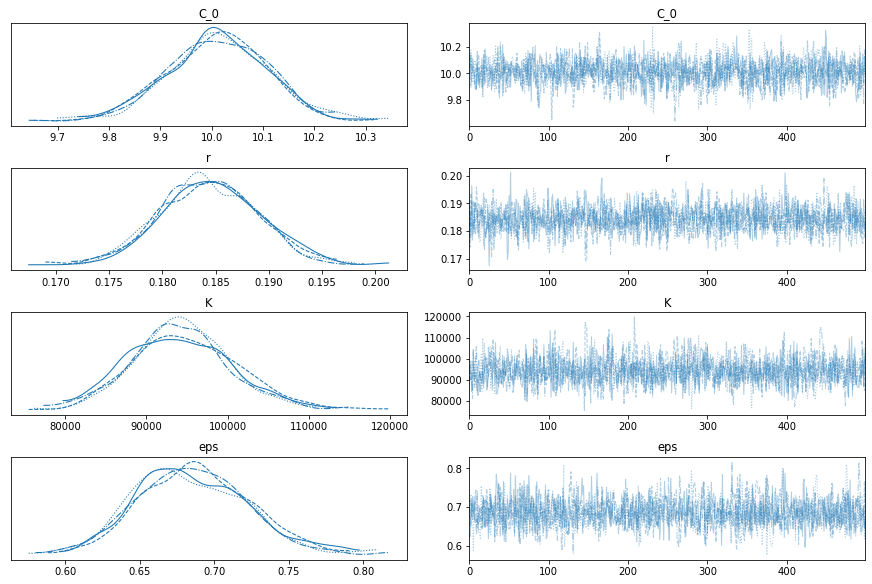

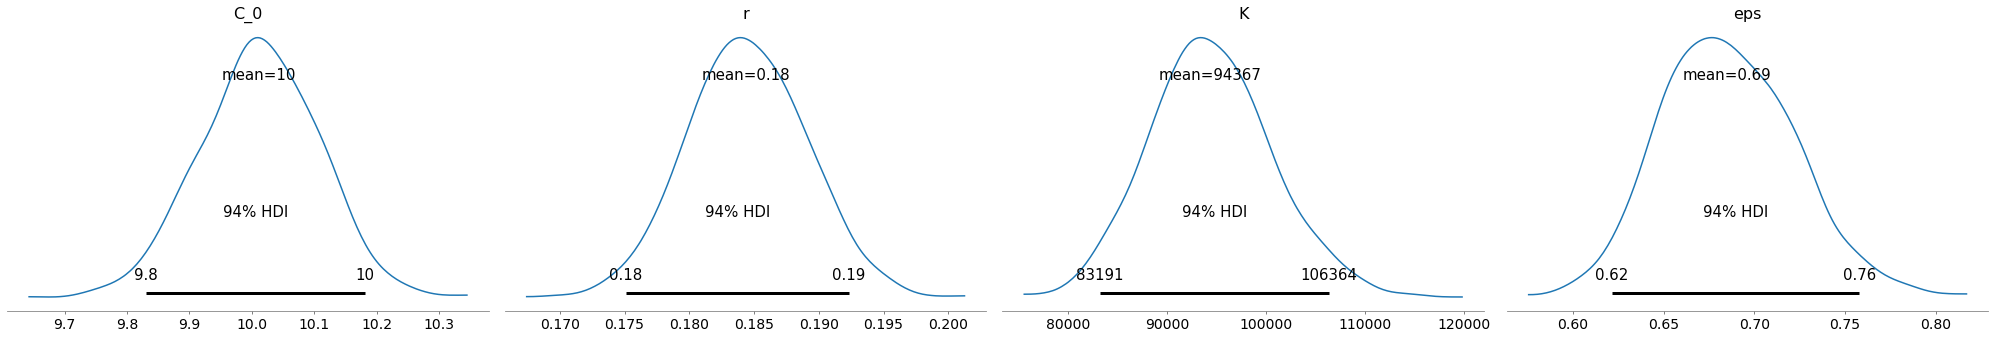

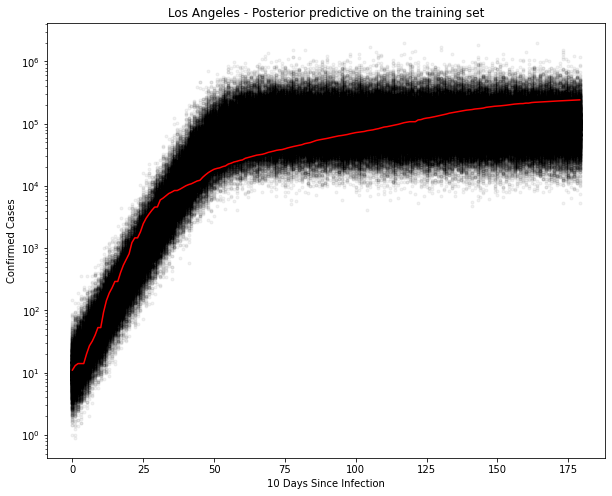

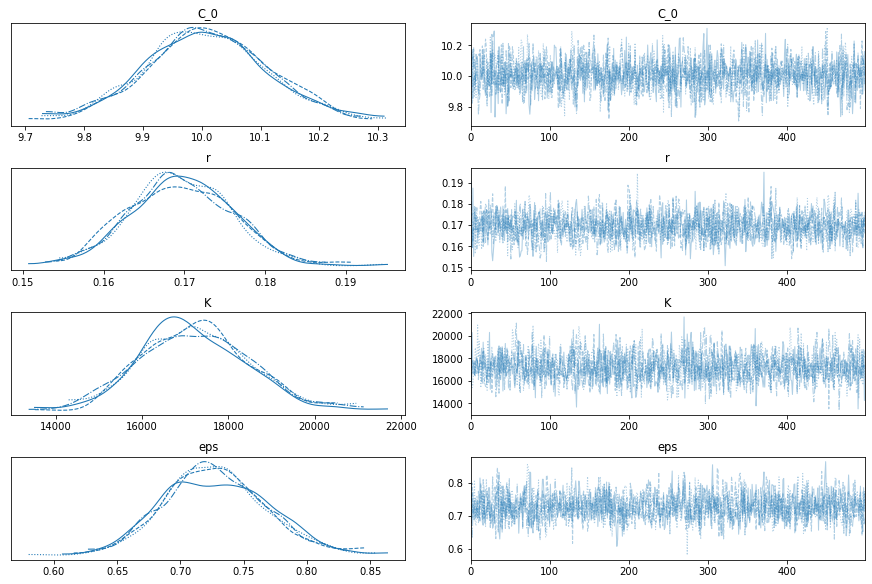

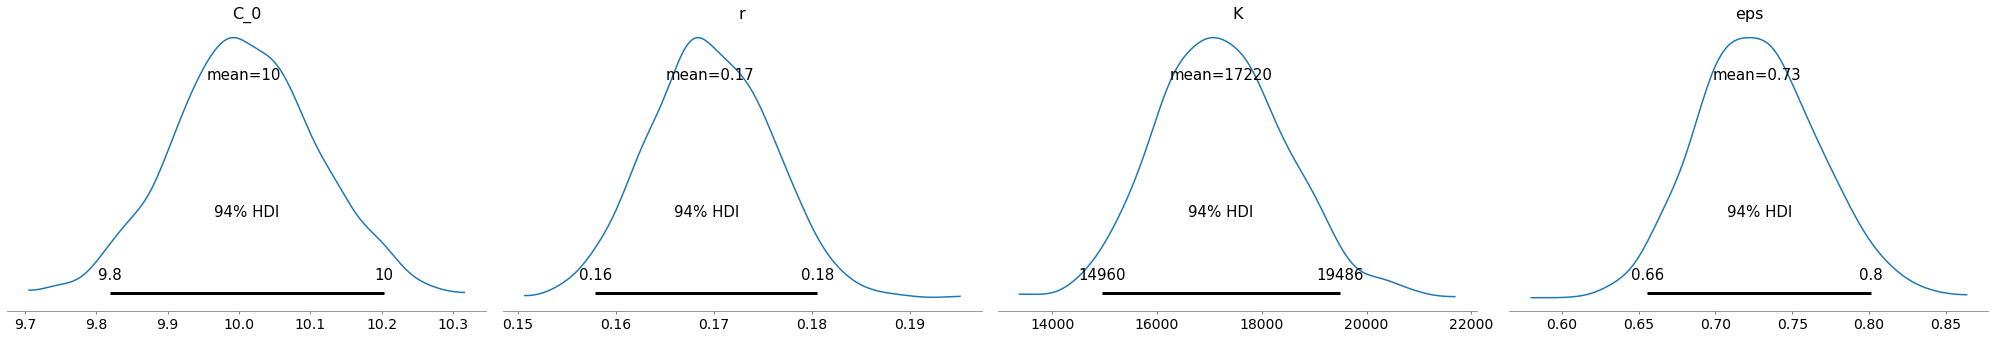

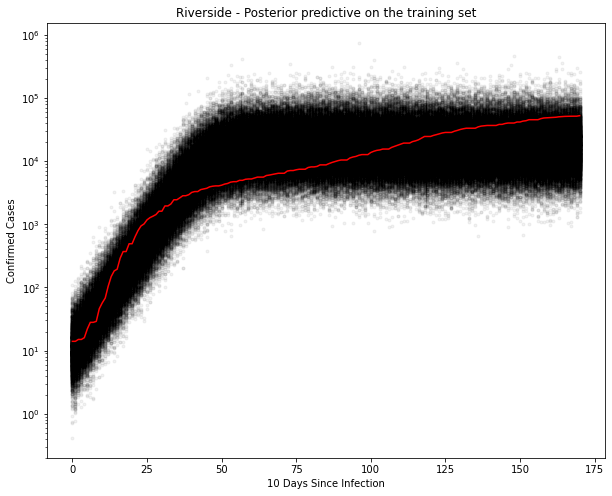

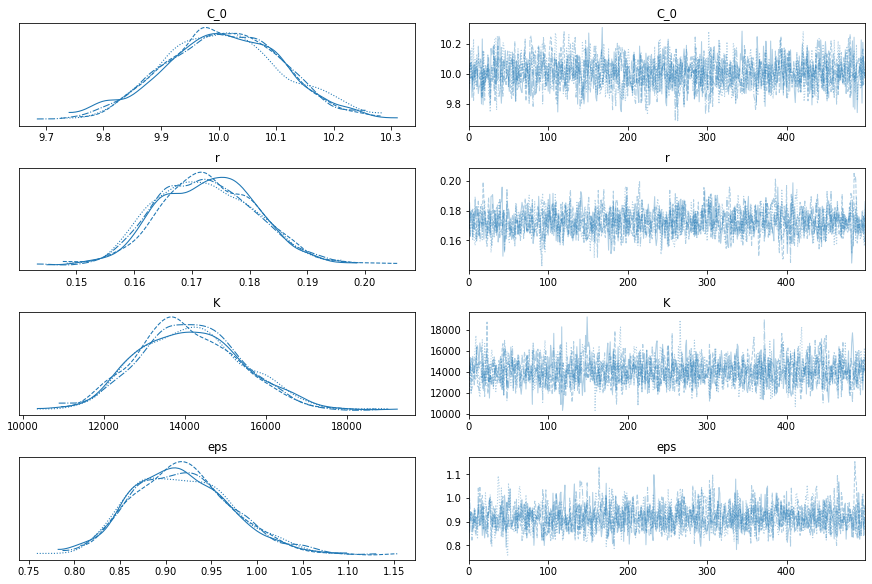

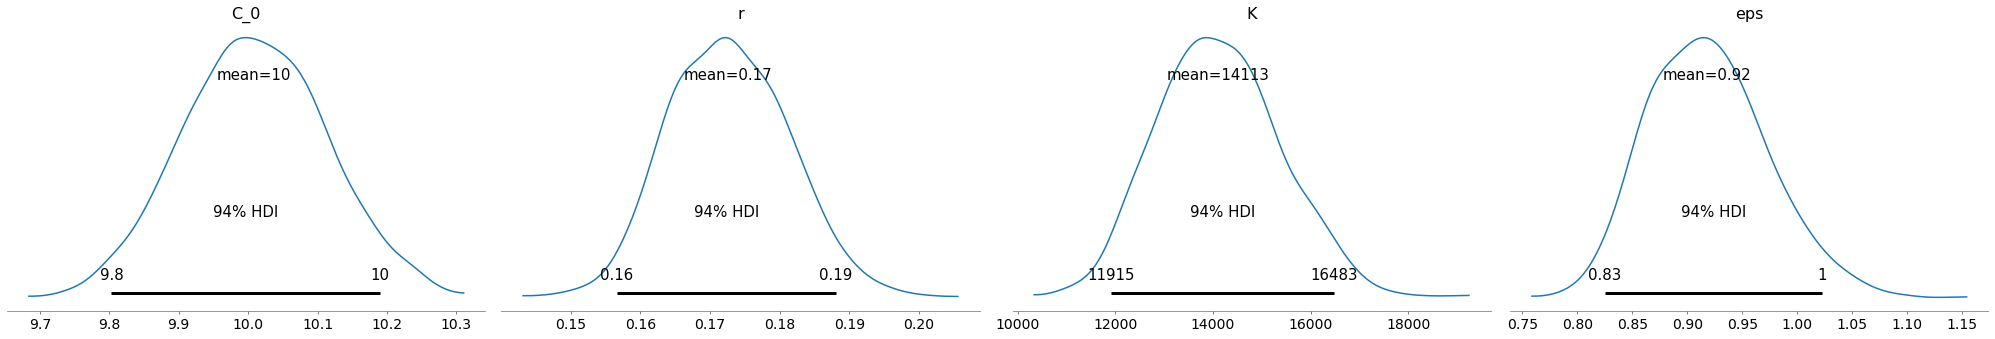

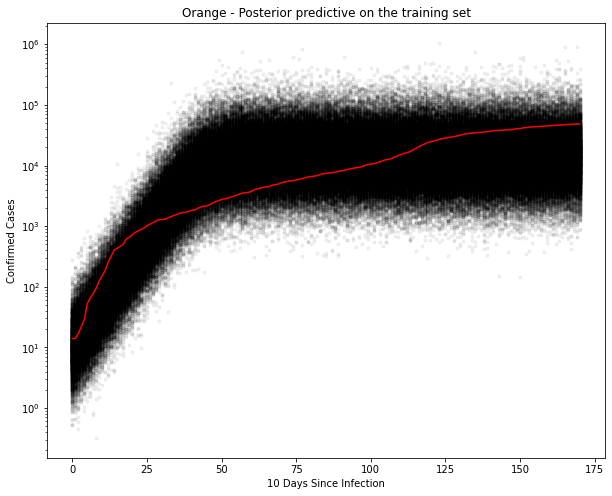

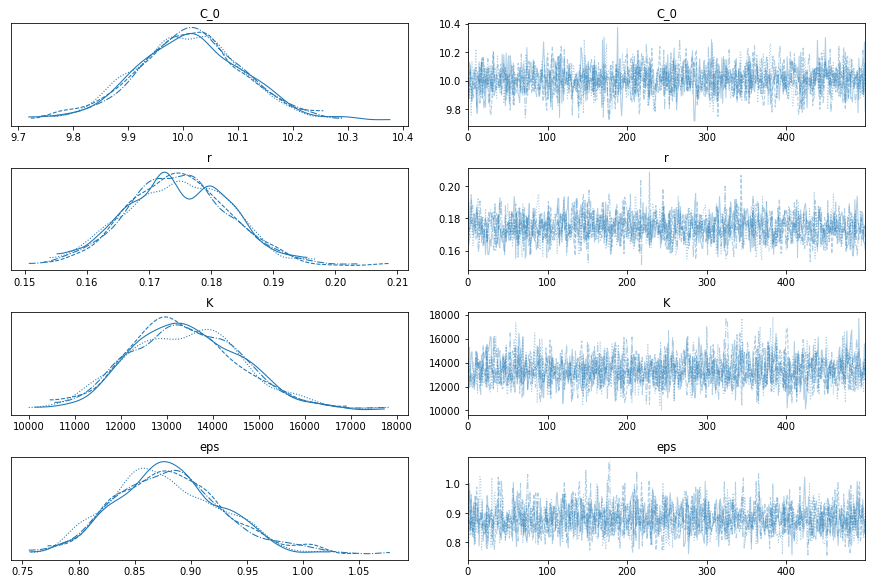

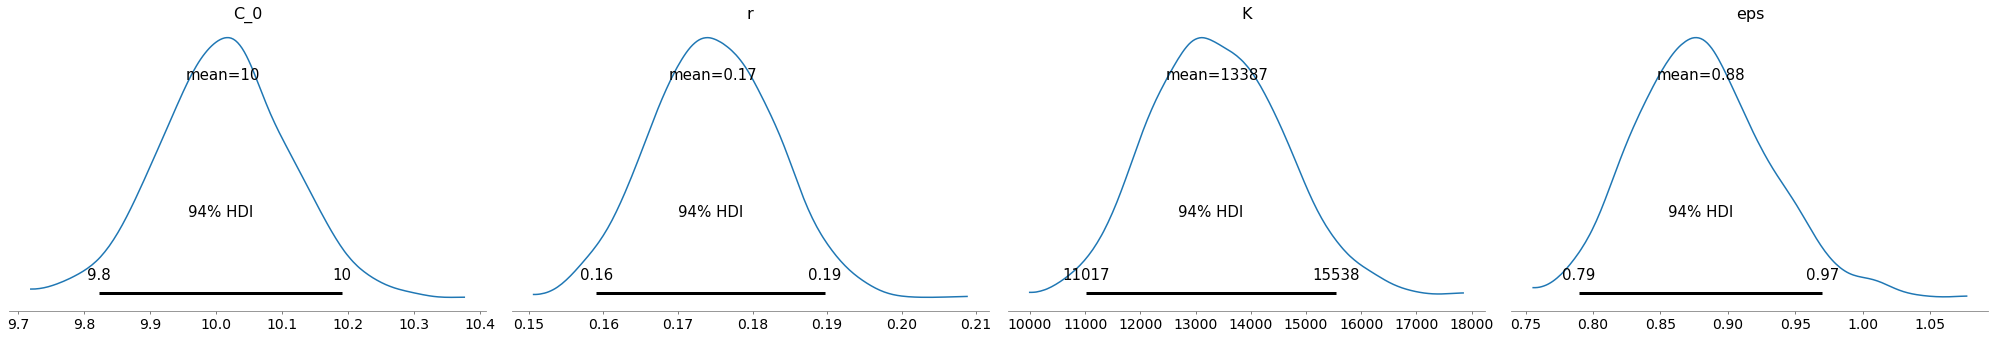

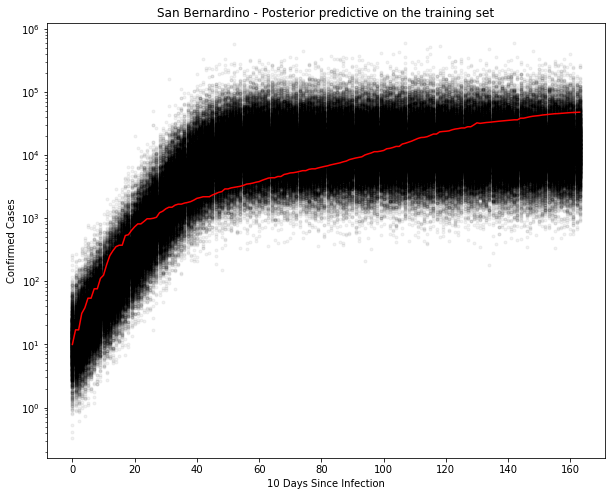

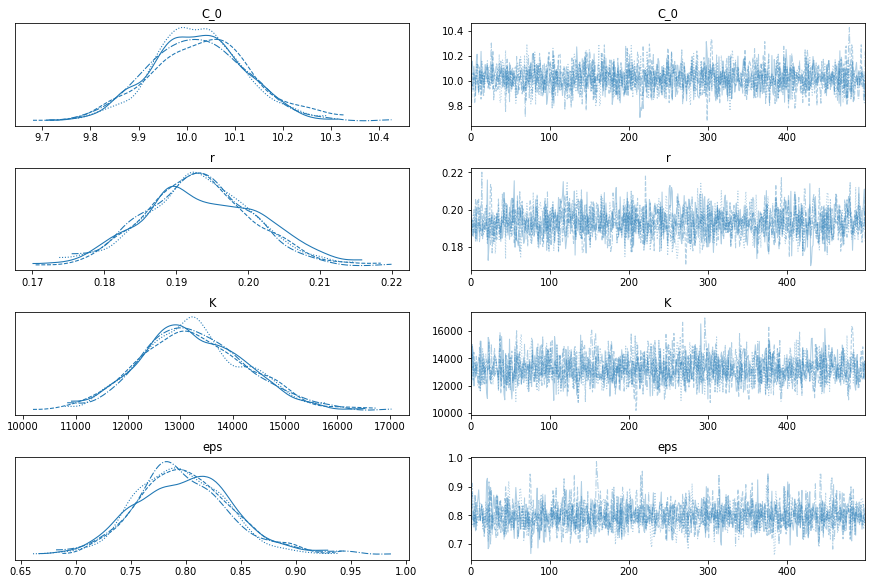

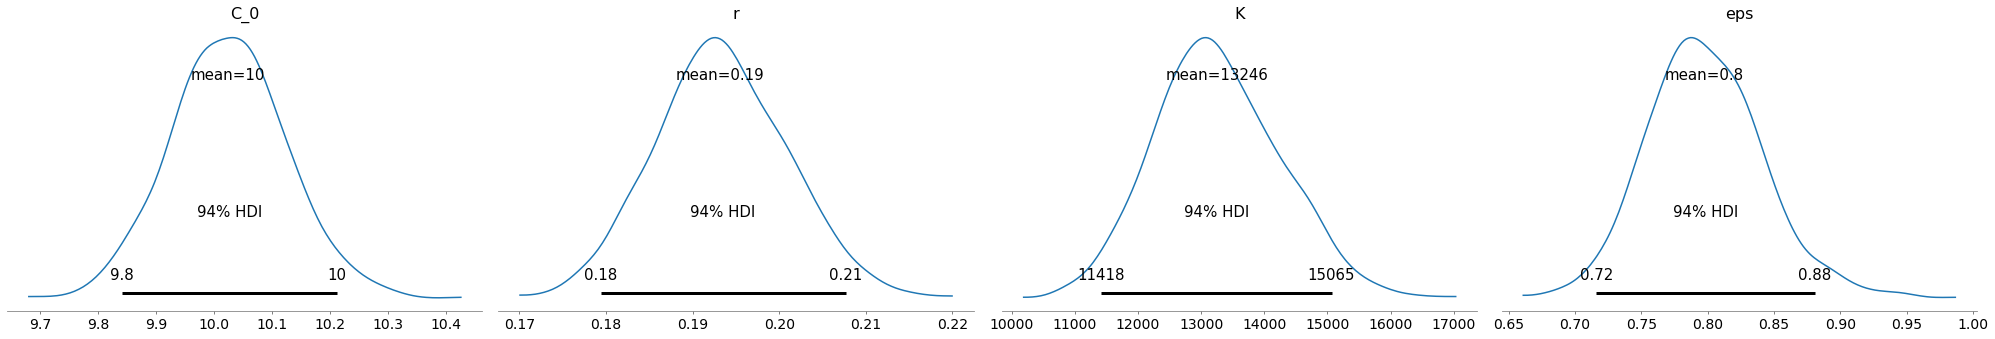

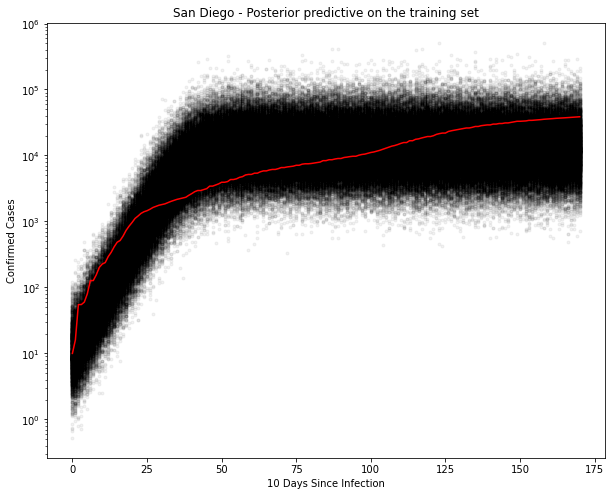

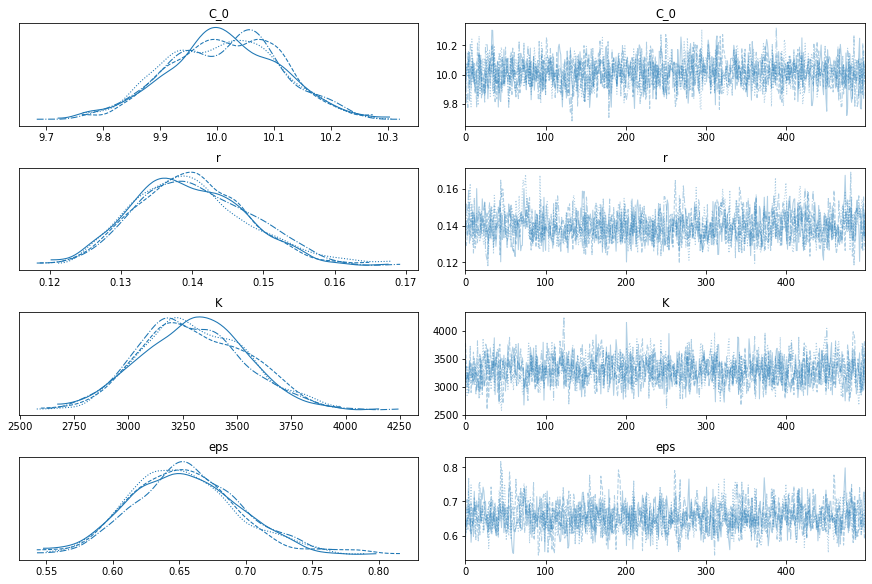

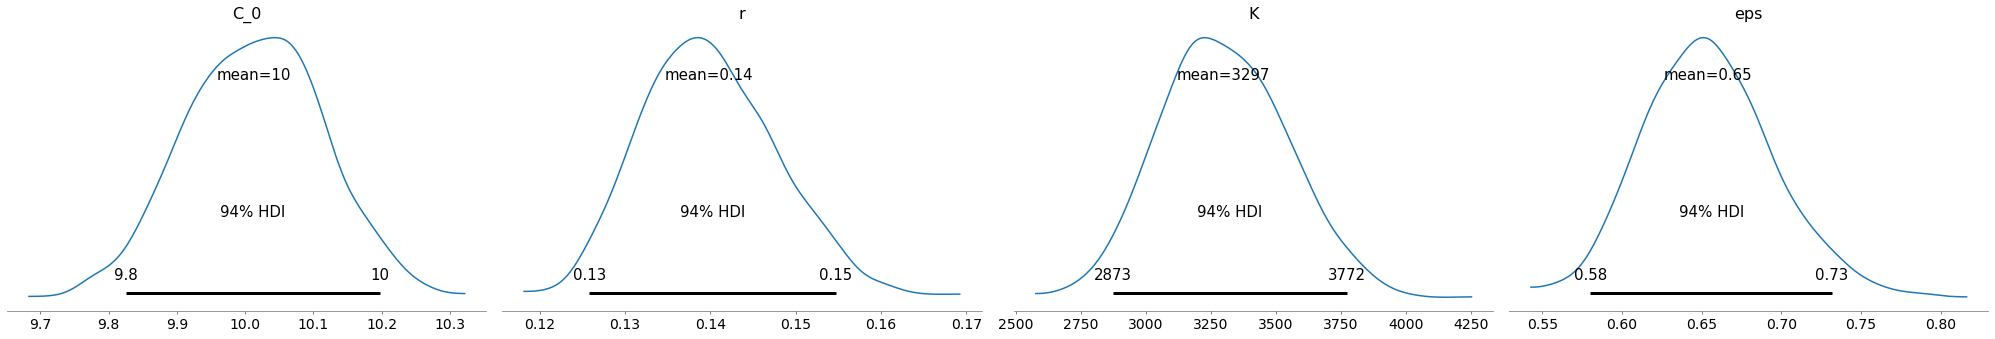

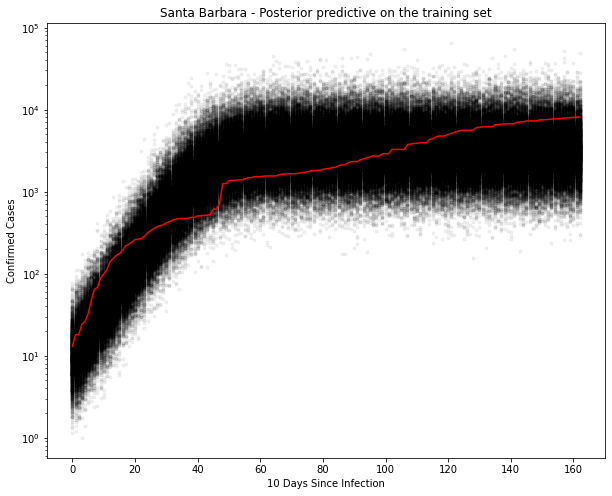

In [151]:

days_since_10 = range(len(la))

for i in range(len(mycounties)):
    x = range(len(cal_10[cal_10['County']== mycounties[i]]['Confirmed']))
    y = cal_10[cal_10['County']== mycounties[i]]['Confirmed']
    with mymodel(mycounties[i], x, y,population[i],infected[i]/population[i]) as model:
        train_trace = pm.sample()
        pm.traceplot(train_trace)
        pm.plot_posterior(train_trace)
        ppc = pm.sample_posterior_predictive(train_trace)
        print(pm.summary(train_trace))
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.plot(x, ppc[mycounties[i]].T, ".k", alpha=0.05)
        ax.plot(x, y, color="r")
        ax.set_yscale("log")
        ax.set(xlabel="10 Days Since Infection", ylabel="Confirmed Cases", title=f"{mycounties[i]} - Posterior predictive on the training set")


In [ ]:
# Questions to consider
# Why errosr become large
# What explains error